### Connection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
import scipy.stats as stats
from graphdatascience import GraphDataScience

URI = "neo4j://localhost:7687"
NAME_DB = "movies"

gds = GraphDataScience(URI, aura_ds=False, database=NAME_DB)

/home/angelo-dev/miniconda3/envs/data_science/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exploratory analysis

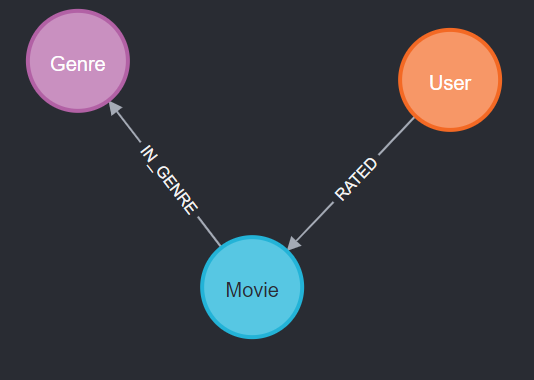

Graph features:
- Directed
- Acyclic
- Unweighted for genre relation and Weighted for rating relation
- Sparse (|edge|<100M)

- todo: system constraints and index in classical and new import
- check for import startup (è meglio creare prima il db, con constraints e indici oppure farlo dopo)
- exploratory analysis normale
- graph analytics con grafi e nodi che aggiungi
- guarda i link della prof e esempi simili
- usa chat gpt

### Distributions of data

In [29]:
occupation_labels={
    0:"other",
    1:  "academic/educator"
	2:  "artist"
	3:  "clerical/admin"
	4:  "college/grad student"
	5:  "customer service"
	6:  "doctor/health care"
	7:  "executive/managerial"
	8:  "farmer"
	9:  "homemaker"
	10:  "K-12 student"
	11:  "lawyer"
	12:  "programmer"
	13:  "retired"
	14:  "sales/marketing"
	15:  "scientist"
	16:  "self-employed"
	17:  "technician/engineer"
	18:  "tradesman/craftsman"
	19:  "unemployed"
	20:  "writer"
}
age_labels={
    1:  "Under 18"
	18:  "18-24"
	25:  "25-34"
	35:  "35-44"
	45:  "45-49"
	50:  "50-55"
	56:  "56+"
}
users = gds.run_cypher(
    """
    MATCH (u:User)
    RETURN u.gender as gender,u.age as age,u.occupation as occupation;
"""
)
users

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4006939171.py, line 3)

<Axes: xlabel='genre'>

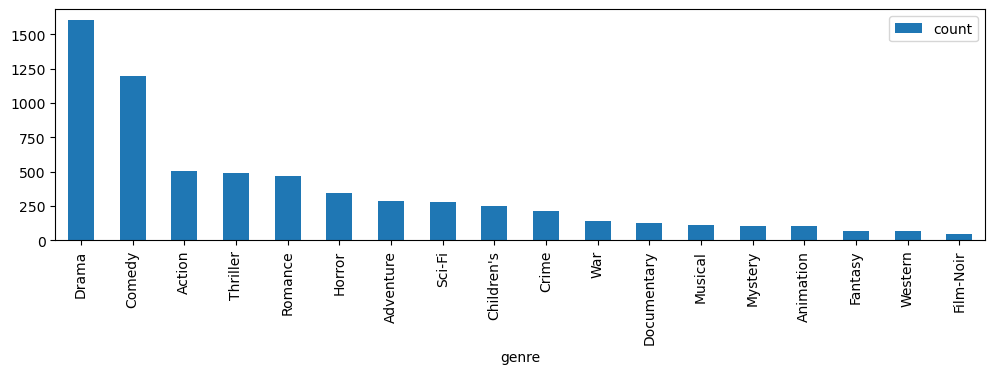

In [25]:
movies_per_genre_distributions = gds.run_cypher(
    """
    MATCH (m:Movie)-[:IN_GENRE]->(g:Genre)
    RETURN g.name as genre, COUNT(m) as count
    ORDER BY count DESC;
"""
)
movies_per_genre_distributions.plot(kind="bar", x="genre", y="count", figsize=(12, 3))

<Axes: xlabel='rating'>

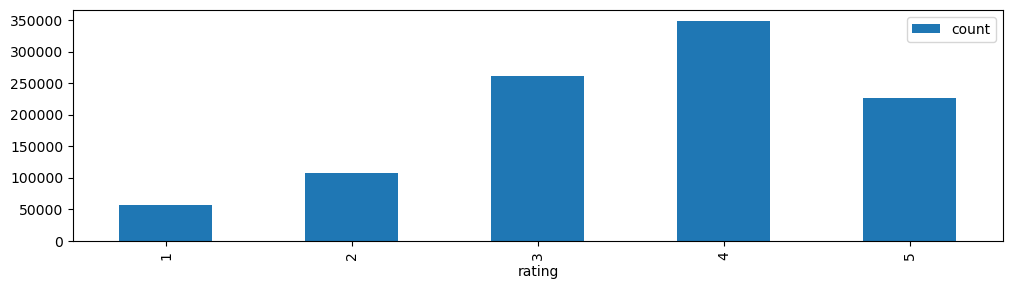

In [23]:
ratings_vote_distribution = gds.run_cypher(
    """
    MATCH (u:User)-[r:RATED]->(m:Movie)
    RETURN r.rating as rating, COUNT(*) as count
    ORDER BY rating;
"""
)
ratings_vote_distribution.plot(kind="bar", x="rating", y="count", figsize=(12, 3))

### Creation of general graph projections
First of all it be created some graph projection for starting exploration of data.  
- 'movies-graph' with all data
- 'movies-users' with all connection (:User)-[:RATED]->(:Movie)
- 'movies-genres' with all connection (:Movie)-[:IN_GENRE]->(:Genre)

In [ ]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'movies-graph',
    '*',
    '*'
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)
result

In [ ]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'movies-users',
    ['User', 'Movie'],
    'RATED'
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)
result

,graph,nodeProjection,nodes,relationshipProjection,rels
0,movies-users,"{'User': {'label': 'User', 'properties': {}}, ...",9923,"{'RATED': {'aggregation': 'DEFAULT', 'orientat...",1000209


In [ ]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'movies-genres',
    ['Movie','Genre'],
    'IN_GENRE'
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)
result

## Connectivity Analysis

### Global connectivity
We have no informations about relations of users, so it's useless calculate diameter.  
The graph structure is in general weakly connected so we can do a global analysis of the weakly connected components and see if there are any distinct groups in the network.

In [19]:
result = gds.run_cypher(
    """
    CALL gds.wcc.stats("movies-graph")
    YIELD componentCount
    """
).componentCount[0]
print(f"In general graph ther's {result} weakly connected component.")
result = gds.run_cypher(
    """
    CALL gds.wcc.stats("movies-genres")
    YIELD componentCount
    """
).componentCount[0]
print(f"And also in movies-genres graph ther's {result} weakly connected component.")
result = gds.run_cypher(
    """
    CALL gds.wcc.stats("movies-users")
    YIELD componentCount
    """
).componentCount[0]
print(f"But in movies-users graph ther're {result} weakly connected component.")

In general graph ther's 1 weakly connected component.
And also in movies-genres graph ther's 1 weakly connected component.
But in movies-users graph ther're 178 weakly connected component.


In [21]:
result = gds.run_cypher(
    """
    CALL gds.wcc.stream("movies-users")
    YIELD nodeId, componentId
    RETURN nodeId as id, componentId
    ORDER BY componentId, id
    """
)
unique_results = result.nunique()
print(
    f"Uniques values of WCC: {unique_results.id} elements in {unique_results.componentId} groups"
)
unique_results = result[result["componentId"] > 0].nunique()
print(
    f"Uniques values of WCC without first group: {unique_results.id} elements in {unique_results.componentId} groups"
)
print(
    f"So {unique_results.componentId} with 1 node for each groups (excluding the firstone)"
)
strange_nodes = result[result["componentId"] > 0]


degree_distribution = gds.run_cypher(
    """
    CALL gds.degree.stream("movies-graph")
    """
)

Uniques values of WCC: 9923 elements in 178 groups
Uniques values of WCC without first group: 177 elements in 177 groups
So 177 with 1 node for each groups (excluding the firstone)


So it is possible to say that ther's a single great weakly connected components and some outliers node without relations.  
A more in-depth analysis will be done later to identify groups within the network

### Local connectivity
Now it can be see the density and its degree distribution stats.  
This graph was chosen because of its higher density compared with the other datasets available on grouplens 

In [ ]:
result = gds.run_cypher(
    """
    CALL gds.graph.list('movies-graph')
    YIELD density,degreeDistribution
"""
)
print(f"Density: {result['density'][0]}")
print(f"Degree distribution: {result['degreeDistribution'][0]}")

Density: 0.010187035096607205
Degree distribution: {'min': 0, 'max': 2314, 'p90': 295, 'p999': 1286, 'p99': 825, 'p50': 35, 'p75': 123, 'p95': 442, 'mean': 101.25912886027562}


Analyzing the degree distribution of the nodes, we can say that the distribution behaves like that of pareto.

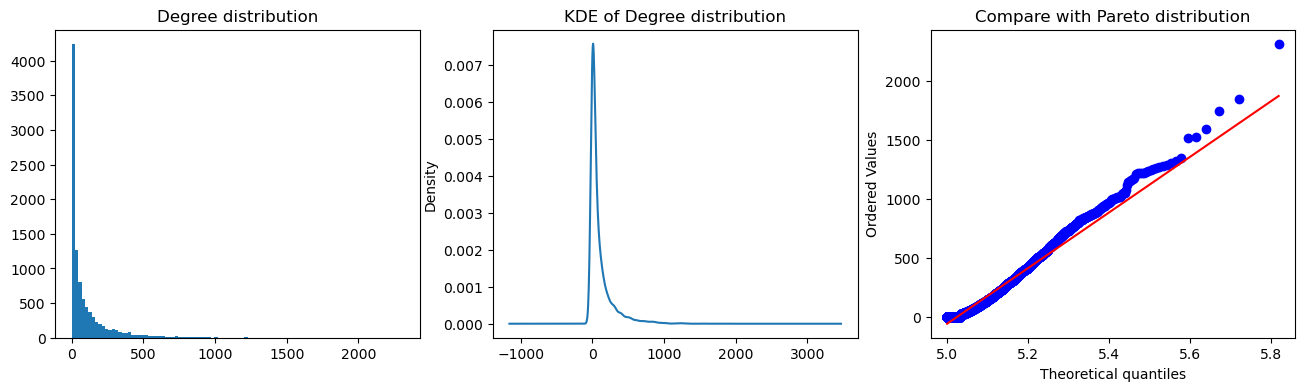

In [ ]:
result = gds.run_cypher(
    """
    CALL gds.degree.stream("movies-graph")
    """
)
degree_distribution = result["score"]
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].hist(degree_distribution, bins=100)
ax[0].set_title("Degree distribution")
degree_distribution.plot.kde(ax=ax[1])
ax[1].set_title("KDE of Degree distribution")
stats.probplot(degree_distribution, dist="pareto", sparams=(16, 4), plot=ax[2])
ax[2].set_title("Compare with Pareto distribution")
plt.show()